# DCGAN on MNIST

## ToDo list

Losses:
* Review losses.
* Why smoothing -> Looking at the gradients.
* Implications of (real+fake)/2 instead of just real+fake

Optimization:
* How Adam works.
* How learning rate evolves.
* Implications of starting with differente learning rates.
* The betas.
* Why Adam and not other optimizers? -> Comparison
* Batch size

Batch Normalization:
* What's that
* Why is so important? -> Comparison
* Momentum.
* Evolution of parameters.

Generator:
* Why that architecture? -> Test with others
* Leaky ReLU vs regular ReLU
* No Dropout
* Zdim of 100

## Theoretical introduction

A training dataset $\boldsymbol{X}$ consists of $m$ samples $\boldsymbol{x}_{i}$ drawn from the ground truth distribution $p_{data}$. The goal of a _generative model_ is to learn $p_{model}$, an estimate of this ground truth distribution $p_{data}$, from the dataset $\boldsymbol{X}$.

Generative Adversarial Networks (GANs) do not estimate explicitly $p_{model}$, but is able to generate samples from it.

$D(\boldsymbol{x}_i)$

$D(G(\boldsymbol{z}))$

$\boldsymbol{z} \sim Unif(-1, 1)$

$$J_D(\boldsymbol{\theta}_D, \boldsymbol{\theta}_G) = -\frac{1}{2} \mathbb{E}_{\boldsymbol{x}} \mathrm{log}D(\boldsymbol{x}) -\frac{1}{2}\mathbb{E}_{\boldsymbol{z}}\mathrm{log}(1 - D(G(\boldsymbol{z})))$$

**I still don't get the E**

But look the parameters of G are important as well to obtain theta_D

But well, I don't know if we are really using that objective function.

We're trying to classify D(x) to the label 1 and D(G(z)) to the label 0. How is that expressed mathematically? That's cross entropy.

```
J_Dreal = -log D(x)              If D=1, J=0.    If D=0, J=+inf

J_Dfake = -log (1 - D(G(z)))     If D=1, J=+inf  If D=0, J=0

J_D = (J_Dreal + J_Dfake)/2

J_D = -(1/2)log D(x) -(1/2)log (1 - D(G(z)))
```

Yep, that's it

**But what about $J_G$**????

## Architecture

<img src="../media/DCGAN_0.png">

Though TensorFlow creates two discriminator modules, they both share the same variables (that's what the yellow fat arrow represents).

<img src="../media/DCGAN_1.png">

<img src="../media/DCGAN_2.png">

## Training

Tensorboard ouputs.

How to interpret tensorboard histograms.

Look at `Generator/Conv_3/bias`. The third convolutional layer of the generator is just one filter, becausewe want its output to be a grayscale image, that is, of `depth=1`. So the bias is just a scalar. All sum up to one...

<img src="../media/DCGAN_3.png">

**Why is there a distribution instead of just one single value?** I just want to know how to differentiate between a plateau and a peak...

Look at `Generator/Conv_2/bias`. This time there are 64 biases. So all sum up to 64.

Look at `Generator/Conv_3/kernel`. That's 1 kernel of 5x5x64. So all sum up to `1*5*5*64=1600`.

Look at `Generator/Conv_2/kernel`. This time there are 64 kernels of 5x5x128. So all sum up to `64*5*5*128=204800`.

In [1]:
import tensorflow as tf
import numpy as np
from __future__ import division

## Data

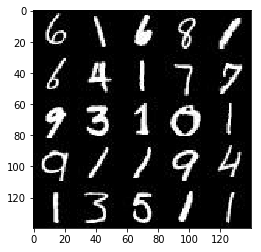

In [2]:
data_dir = './../data'

import sys
sys.path.insert(0, data_dir)

import helper

show_n_images = 25

%matplotlib inline
import os
from glob import glob
import matplotlib.pyplot as plt

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')

plt.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray');

## Inputs

In [3]:
def model_inputs(img_w, img_h, img_channels, z_dim):

    inputs_real = tf.placeholder(tf.float32, (None, img_w, img_h, img_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')

    return inputs_real, inputs_z

## Generator

**SHIT**: The model is fixed for inputs of size 28x28x(1 or 3)


**NOTE**: We have set `epsilon=0.8` as done in the PyTorch implementation.

**NOTE**: We have left `strides=2` in the *Deconvolutional Layer* (not regular convolutional), instead of using `Upsample(scale_factor=2)` and `stride=1` as done in the PyTorch implementation.

**NOTE**: We have left `kernel_size=5`, instead of using a kerenel of 3 as done in the PyTorch implementation.

**TODO**: We need to set some parameters as easily-modifiable hyperparameters:
* Momentum.
* Alpha
* Number of conv layers
* Size of conv layers

In [4]:
def generator(z, out_channels, is_train=True, alpha=0.2, momentum=0.8):
    
    with tf.variable_scope('Generator', reuse=not(is_train)):
            
        # ? -> 7x7x256
        with tf.variable_scope('FC', reuse=not(is_train)):
            fc = tf.layers.dense(z, 7*7*256, name='FullyConn')
            fc = tf.reshape(fc, (-1, 7, 7, 256), name='Reshape')
            fc = tf.layers.batch_normalization(fc, training=is_train, name='BatchNorm')
            fc = tf.nn.leaky_relu(fc, alpha, name='out')

        # 7x7x256 -> 14x14x128
        with tf.variable_scope('Conv_1', reuse=not(is_train)):
            conv1 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same', name="Conv2D")
            conv1 = tf.layers.batch_normalization(conv1, momentum=momentum, training=is_train, name='BatchNorm')
            conv1 = tf.nn.leaky_relu(conv1, alpha, name='out')

        # 14x14x128 -> 28x28x64
        with tf.variable_scope('Conv_2', reuse=not(is_train)):
            conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='same', name="Conv2D")
            conv2 = tf.layers.batch_normalization(conv2, momentum=momentum, training=is_train, name='BatchNorm')
            conv2 = tf.nn.leaky_relu(conv2, alpha, name='out')

        # 28x28x64 -> 28x28x(1 or 3)
        conv3 = tf.layers.conv2d_transpose(conv2, out_channels, 5, strides=1, padding='same', name="Conv_3")

        out = tf.tanh(conv3, name='out')
    
    return out

## Discriminator

**NOTE**: We have used the entire architecture proposed in the PyTorch implementation.

In [5]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75, momentum=0.8):
    
    with tf.variable_scope('Discriminator', reuse=reuse):
        
        with tf.variable_scope('Conv_1', reuse=reuse):
            conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', name="Conv2D")
            conv1 = tf.nn.leaky_relu(conv1, alpha, name='L-ReLU')
            conv1 = tf.nn.dropout(conv1, keep_prob, name='out')

        with tf.variable_scope('Conv_2', reuse=reuse):
            conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', name="Conv2D")
            conv2 = tf.nn.leaky_relu(conv2, alpha, name='L-ReLU')
            conv2 = tf.nn.dropout(conv2, keep_prob, name='Dropout')
            conv2 = tf.layers.batch_normalization(conv2, momentum=momentum, training=True, name='out')
    
        with tf.variable_scope('Conv_3', reuse=reuse):
            conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', name="Conv2D")
            conv3 = tf.nn.leaky_relu(conv3, alpha, name='L-ReLU')
            conv3 = tf.nn.dropout(conv3, keep_prob, name='Dropout')
            conv3 = tf.layers.batch_normalization(conv3, momentum=momentum, training=True, name='out')

        conv3_shape = conv3.get_shape().as_list()
        flatten_shape = conv3_shape[1] * conv3_shape[2] * conv3_shape[3]
        
        with tf.variable_scope('FC', reuse=reuse):
            flat = tf.reshape(conv3, (-1, flatten_shape), "Flatten")
            logits = tf.layers.dense(flat, 1, name='out')

        out = tf.sigmoid(logits, name='out')

    return out, logits

## Loss functions

Cross entropy vs MSE

**NOTE**: We have removed smoothing in the discriminator loss.

**NOTE**: We have divided `d_loss` by two, as in the PyTorch implementation.

In [6]:
def model_loss(input_real, input_z, out_channels, smooth=0.05):
    
    g = generator(input_z, out_channels)
    d_real, d_logits_real = discriminator(input_real)
    d_fake, d_logits_fake = discriminator(g, reuse=True)
    
    with tf.name_scope("Losses"):
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_fake)),
            name="G_Loss")

        with tf.name_scope("D_Loss") as scope:
            d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_real,
                    labels=tf.ones_like(d_real)*(1-smooth)),
                name="D_Loss_Real")
            d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake,
                    labels=tf.zeros_like(d_fake)+smooth),
                name="D_Loss_Fake")

            d_loss = (d_loss_real + d_loss_fake)/2
            d_loss = tf.identity(d_loss, name=scope)
    
    
    # Summaries
    tf.summary.scalar('g_loss', g_loss)
    tf.summary.scalar('d_loss_real', d_loss_real)
    tf.summary.scalar('d_loss_fake', d_loss_fake)
    tf.summary.scalar('d_loss', d_loss)

    tf.summary.image('g_images', g, 1)
    
    return g_loss, d_loss

In [7]:
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate, beta1, beta2=0.999):
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('Generator')]
    d_vars = [var for var in t_vars if var.name.startswith('Discriminator')]
    
    #print g_vars, d_vars # Cool to see the variables you have
    for var in t_vars:
        tf.summary.histogram(var.name[:-2], var) # [:-2] to remove ':0' from tensor name
    
    # Optimize
    with tf.name_scope("Optimizers"):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            g_train_opt = tf.train.AdamOptimizer(learning_rate=g_learning_rate,
                                                 beta1=beta1,
                                                 beta2=beta2, name='G_Adam').minimize(g_loss, var_list=g_vars)
            
            d_train_opt = tf.train.AdamOptimizer(learning_rate=d_learning_rate,
                                                 beta1=beta1,
                                                 beta2=beta2, name='D_Adam').minimize(d_loss, var_list=d_vars)
    
    return g_train_opt, d_train_opt

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

data_shape = [1, 28, 28, 3]

tf.reset_default_graph()
    
input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) # placeholders
g_loss, d_loss = model_loss(input_real, input_z, data_shape[3]) # loss
g_opt, d_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

with tf.Session() as sess:
    writer = tf.summary.FileWriter('/tmp/1')
    writer.add_graph(sess.graph)

In [8]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [9]:
def train(epoch_count, batch_size, z_dim, g_learning_rate, d_learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    input_real, input_z = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) # placeholders
    g_loss, d_loss = model_loss(input_real, input_z, data_shape[3]) # loss
    g_opt, d_opt = model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate, beta1) # optimizers
    
    save_dir = '/tmp/dcgan/dcgan_mnist.ckpt'
    saver = tf.train.Saver()
    
    log_dir = '/tmp/dcgan/tb/mnist'
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(log_dir)
    
    steps = 0
    
    with tf.Session() as sess:
        
        writer.add_graph(sess.graph)
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(g_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z
                    })
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z
                    })
                
                if steps % 20 == 0:
                    summary = sess.run(merged_summary, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    writer.add_summary(summary, steps)
                    
                    #train_loss_d = sess.run(d_loss, feed_dict={
                    #    input_z: batch_z,
                    #    input_real: batch_images
                    #    })
                    #train_loss_g = sess.run(g_loss, feed_dict={
                    #    input_z: batch_z
                    #})
                    
                    #print("Epoch {}/{}...".format(epoch_i+1, epochs),
                    #      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                    #      "Generator Loss: {:.4f}".format(train_loss_g))
                    print "Epoch: {}, Steps: {}".format(epoch_i+1, steps)
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, save_dir)

Steps: 20
Steps: 40
Steps: 60
Steps: 80
Steps: 100


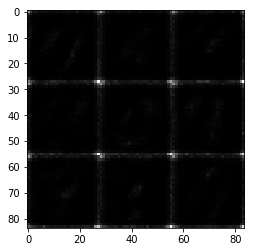

Steps: 120
Steps: 140
Steps: 160
Steps: 180
Steps: 200


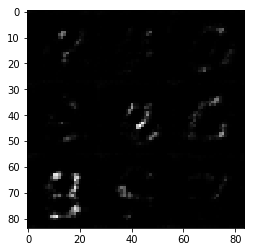

Steps: 220
Steps: 240
Steps: 260
Steps: 280
Steps: 300


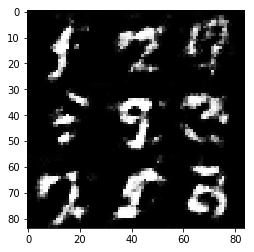

Steps: 320
Steps: 340
Steps: 360
Steps: 380
Steps: 400


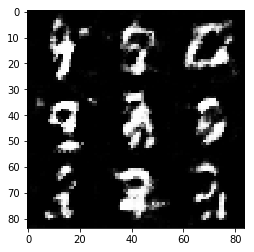

Steps: 420
Steps: 440
Steps: 460
Steps: 480
Steps: 500


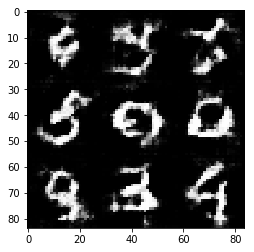

Steps: 520
Steps: 540
Steps: 560
Steps: 580
Steps: 600


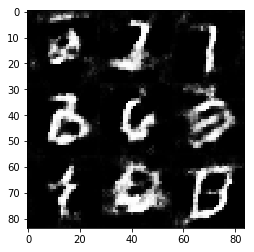

Steps: 620
Steps: 640
Steps: 660
Steps: 680
Steps: 700


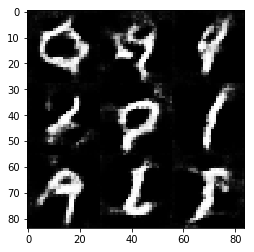

Steps: 720
Steps: 740
Steps: 760
Steps: 780
Steps: 800


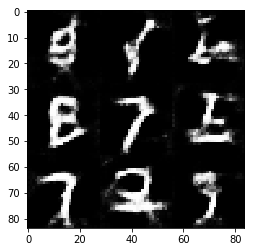

Steps: 820
Steps: 840
Steps: 860
Steps: 880
Steps: 900


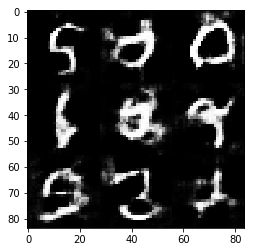

Steps: 920
Steps: 940
Steps: 960
Steps: 980
Steps: 1000


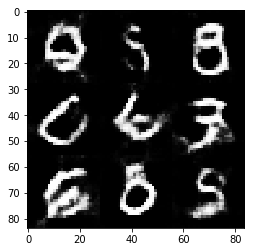

Steps: 1020
Steps: 1040
Steps: 1060
Steps: 1080
Steps: 1100


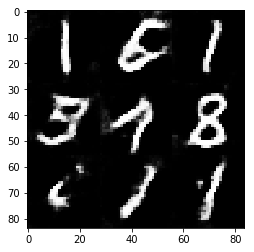

Steps: 1120
Steps: 1140
Steps: 1160
Steps: 1180
Steps: 1200


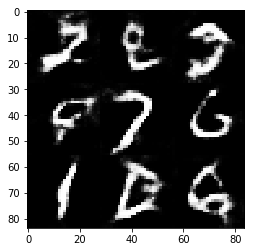

Steps: 1220
Steps: 1240
Steps: 1260
Steps: 1280
Steps: 1300


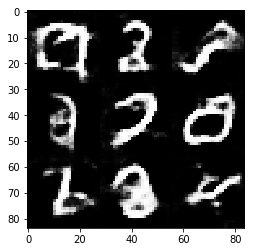

Steps: 1320
Steps: 1340
Steps: 1360
Steps: 1380
Steps: 1400


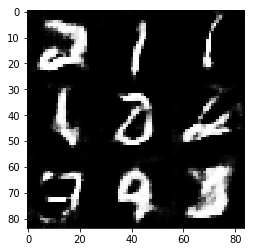

Steps: 1420
Steps: 1440
Steps: 1460
Steps: 1480
Steps: 1500


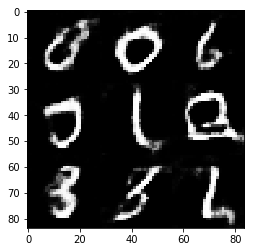

Steps: 1520
Steps: 1540
Steps: 1560
Steps: 1580
Steps: 1600


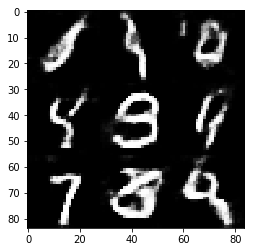

Steps: 1620
Steps: 1640
Steps: 1660
Steps: 1680
Steps: 1700


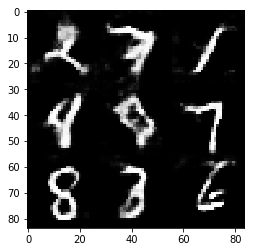

Steps: 1720
Steps: 1740
Steps: 1760
Steps: 1780
Steps: 1800


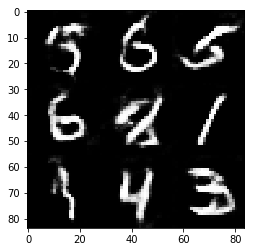

Steps: 1820
Steps: 1840
Steps: 1860


In [10]:
batch_size = 64
z_dim = 100
g_learning_rate = 0.0002
d_learning_rate = 0.0002
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset(glob(os.path.join(data_dir, 'mnist/*.jpg')), 28, 28, 1, conditional=False)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, g_learning_rate, d_learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Man, I'm just a shit of a person.

I messed it up with the losses and optimizers, feeding the generator with the D loss and vice versa. I'm the fucking worse and I've lost a day on this.

OK so, when you get a very weak discriminator... you probably have messed it up, because that's just tooo uncommon

I want to use tensorboard to get information about how variables are changing and stuff.
Losses, learning rates...

I also want to reuse the discriminator with other dataset.

https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

https://deeplearning4j.org/generative-adversarial-network

tf.summary.scalar('g_loss', g_loss)
tf.summary.scalar('d_loss', d_loss)

tf.summary.image('g_images', g, 1)

tf.summary.histogram()

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir)
writer.add_graph(sess.graph)

s = sess.run(merged_summary, feed_dict{
    
})
writer.add_summary(s, ?)